# Pytorch-shap-预训练图像分类可解释性分析

对Pytorch模型库中的ImageNet预训练图像分类模型进行可解释性分析。可视化指定预测类别的shap值热力图。

## 导入工具包

In [4]:
import json
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import shap
from train_come15k import copy_state_dict

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [34]:
# 数据集文件夹路径
dataset_name = 'test_easy_classes'
model_path = 'models/2023-09-24-15:52_max_epoch_50/'
model_name = 'retrain_COME15K_checkpoint-best-avg-0.735-Medium.pth.tar'
dataset_dir = '../data_class_txt/'+ dataset_name + '.txt'
# 忽略烦人的红色提示
import warnings
warnings.filterwarnings("ignore")

# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)
dataset_name = 'test_easy_classes'
model_path = 'models/2023-09-24-15:52_max_epoch_50/'

# 类别名称 和 ID索引号 的映射字典
class_names_dic = {0: 'covering', 1: 'device', 2: 'domestic_animal', 3: 'mater', 4: 'person', 5: 'plant',
                       6: 'structure', 7: 'vertebrate'}
# 获得类别名称
class_names = list(class_names_dic.values())
print(class_names)

device cuda:0
['covering', 'device', 'domestic_animal', 'mater', 'person', 'plant', 'structure', 'vertebrate']


## 载入预训练图像分类模型(ImageNet1K)

In [2]:
from network import ShuffleNetV2_Plus
## 载入ImageNet1k预训练图像分类模型

# init model choose ['Small','Medium','Large']
model_size = 'Medium'
architecture = [0, 0, 3, 1, 1, 1, 0, 0, 2, 0, 2, 1, 1, 0, 2, 0, 2, 1, 3, 2]
model = ShuffleNetV2_Plus(architecture=architecture, n_class=class_names.__len__(), model_size=model_size)
pre_train_model_weight_dic = {
    'Small': 'shuffle_net_v2_plus_image1K_pretrianed_weight/ShuffleNetV2+.ImageNet1k_pre_trained_Small.pth.tar',
    'Medium': 'shuffle_net_v2_plus_image1K_pretrianed_weight/ShuffleNetV2+.ImageNet1k_pre_trained_Medium.pth.tar',
    'Large': 'shuffle_net_v2_plus_image1K_pretrianed_weight/ShuffleNetV2+.ImageNet1k_pre_trained_Large.pth.tar'
    }
# 载入预训练
pre_train_weight = torch.load(pre_train_model_weight_dic[model_size])
# 去掉分类层
new_dict = copy_state_dict(pre_train_weight)
keys = []
for k, v in new_dict.items():
    if k.startswith('classifier'):  # 将‘’开头的key过滤掉，这里是要去除的层的key
        continue
    keys.append(k)
new_dict = {k: new_dict[k] for k in keys}
state_dict = new_dict
model.load_state_dict(state_dict, strict=False)

model size is  Medium


_IncompatibleKeys(missing_keys=['classifier.0.weight'], unexpected_keys=[])

## 载入预训练图像分类模型(COME15K-DATASET)

In [6]:
# 数据集文件夹路径
dataset_name = 'test_easy_classes'
model_path = 'models/2023-09-25-17:12_max_epoch_50/'
model_name = 'retrain_COME15K_checkpoint-best-easy-0.736-Medium.pth.tar'
dataset_dir = '../data_class_txt/'+ dataset_name + '.txt'
# init model
model_and_weight_path = model_path + model_name
model = torch.load(model_and_weight_path)
model = model.eval().to(device)
model

ShuffleNetV2_Plus(
  (first_conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.0012468827930174563, affine=True, track_running_stats=True)
    (2): HS()
  )
  (features): Sequential(
    (0): Shufflenet(
      (branch_main): Sequential(
        (0): Conv2d(16, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.0012468827930174563, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (4): BatchNorm2d(24, eps=1e-05, momentum=0.0012468827930174563, affine=True, track_running_stats=True)
        (5): Conv2d(24, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (6): BatchNorm2d(32, eps=1e-05, momentum=0.0012468827930174563, affine=True, track_running_stats=True)
        (7): ReLU(inplace=True)
      )
     

## 载入一张测试图像，整理维度

In [9]:
# img_path = 'test_img/test_草莓.jpg'

img_path = 'data/SOD-SemanticDataset-OriginalSize/test/COME15K-Easy/COME_Easy_1.jpg'

In [10]:
img_pil = Image.open(img_path)
X = torch.Tensor(np.array(img_pil)).unsqueeze(0)

In [11]:
X.shape

torch.Size([1, 344, 623, 3])

## 预处理

In [12]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x

def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x 
        

transform= [
    transforms.Lambda(nhwc_to_nchw),
    transforms.Resize(224),
    transforms.Lambda(lambda x: x*(1/255)),
    transforms.Normalize(mean=mean, std=std),
    transforms.Lambda(nchw_to_nhwc),
]

inv_transform= [
    transforms.Lambda(nhwc_to_nchw),
    transforms.Normalize(
        mean = (-1 * np.array(mean) / np.array(std)).tolist(),
        std = (1 / np.array(std)).tolist()
    ),
    transforms.Lambda(nchw_to_nhwc),
]

transform = torchvision.transforms.Compose(transform)
inv_transform = torchvision.transforms.Compose(inv_transform)

## 构建模型预测函数

In [13]:
def predict(img: np.ndarray) -> torch.Tensor:
    img = nhwc_to_nchw(torch.Tensor(img)).to(device)
    output = model(img)
    return output

In [14]:
def predict(img):
    img = nhwc_to_nchw(torch.Tensor(img)).to(device)
    output = model(img)
    return output

## 测试整个工作流正常

In [15]:
Xtr = transform(X)
out = predict(Xtr[0:1])

In [16]:
out.shape

torch.Size([1, 8])

In [45]:
classes = torch.argmax(out, axis=1).detach().cpu().numpy()
print(classes)
print(f'Classes: {classes}: {np.array(class_names)[classes]}')

[3]
Classes: [3]: ['mater']


## 设置shap可解释性分析算法

In [46]:
# 构造输入图像
input_img = Xtr[0].unsqueeze(0)

In [47]:
input_img.shape

torch.Size([1, 224, 405, 3])

In [57]:
batch_size = 50

n_evals = 5000 # 迭代次数越大，显著性分析粒度越精细，计算消耗时间越长

# 定义 mask，遮盖输入图像上的局部区域
masker_blur = shap.maskers.Image("blur(64, 64)", Xtr[0].shape)

# 创建可解释分析算法
explainer = shap.Explainer(predict, masker_blur, output_names=class_names)

## 指定单个预测类别

In [58]:
shap_values = explainer(input_img, max_evals=n_evals, batch_size=batch_size, outputs=[0])

Partition explainer: 2it [00:11, 11.02s/it]                                     


In [59]:
# 整理张量维度
shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0] # 原图
shap_values.values = [val for val in np.moveaxis(shap_values.values[0],-1, 0)] # shap值热力图

In [60]:
# 原图
shap_values.data.shape

(224, 405, 3)

In [61]:
# shap值热力图
shap_values.values[0].shape

(224, 405, 3)

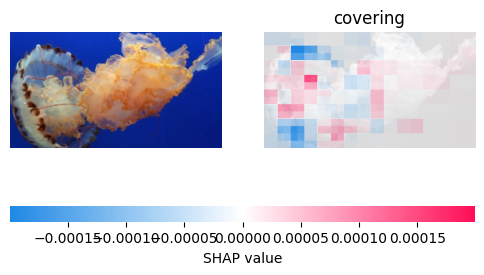

In [62]:
# 可视化
shap.image_plot(shap_values=shap_values.values,
                pixel_values=shap_values.data,
                labels=shap_values.output_names)

## 指定多个预测类别

In [63]:
shap_values = explainer(input_img, max_evals=n_evals, batch_size=batch_size, outputs=[0, 1, 2, 3])

Partition explainer: 2it [00:10, 10.94s/it]                                     


In [64]:
# 整理张量维度
shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0] # 原图
shap_values.values = [val for val in np.moveaxis(shap_values.values[0],-1, 0)] # shap值热力图

In [65]:
# shap值热力图：每个像素，对于每个类别的shap值
shap_values.shape

(4, 224, 405, 3)

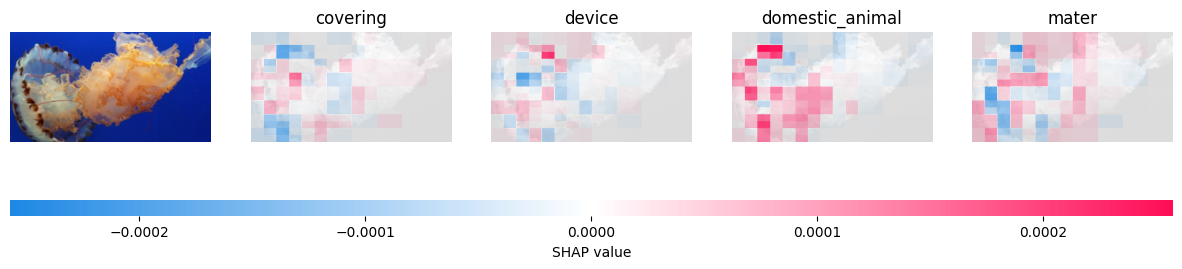

In [66]:
# 可视化
shap.image_plot(shap_values=shap_values.values,
                pixel_values=shap_values.data,
                labels=shap_values.output_names)

## 前k个预测类别

In [75]:
topk = 8

In [76]:
shap_values = explainer(input_img, max_evals=n_evals, batch_size=batch_size, outputs=shap.Explanation.argsort.flip[:topk])

Partition explainer: 2it [00:10, 10.91s/it]                                     


In [77]:
# shap值热力图：每个像素，对于每个类别的shap值
shap_values.shape

(1, 224, 405, 3, 8)

In [78]:
# 整理张量维度
shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0] # 原图
shap_values.values = [val for val in np.moveaxis(shap_values.values[0],-1, 0)] # 各个类别的shap值热力图

In [79]:
# 各个类别的shap值热力图
len(shap_values.values)

8

In [80]:
# 第一个类别，shap值热力图
shap_values.values[0].shape

(224, 405, 3)

In [81]:
# 第一个类别，shap值热力图
shap_values.values[1].shape

(224, 405, 3)

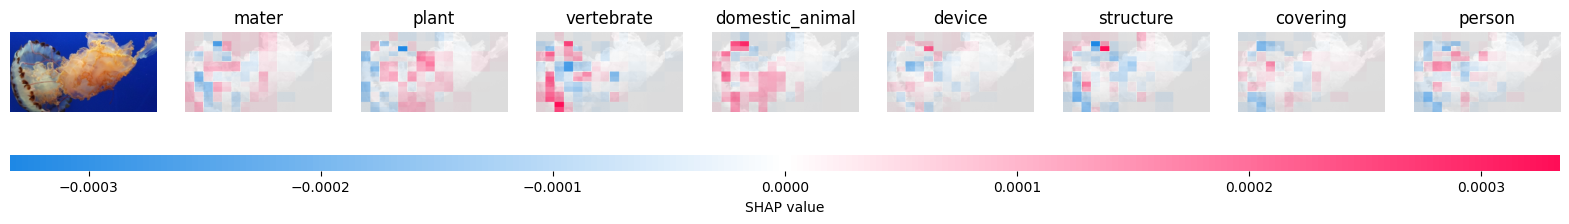

In [82]:
# 可视化
shap.image_plot(shap_values=shap_values.values,
                pixel_values=shap_values.data,
                labels=shap_values.output_names
                )